## 1.Environment Setup

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler

# Đặt seed để đảm bảo nhất quán giữa các lần chạy
# os.environ["PYTHONHASHSEED"] = "42"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print("Seed = ", RANDOM_SEED)

Seed =  42


## 2.Data Processing

In [2]:
# cleveland.csv
# https://drive.google.com/file/d/16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju/view?usp=sharing
!gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju

Downloading...
From: https://drive.google.com/uc?id=16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju
To: /home/banhmuy/data-science-artificial-intelligence-projects/Heart-Disease-Diagnosis/notebooks/cleveland.csv
100%|██████████████████████████████████████| 10.9k/10.9k [00:00<00:00, 22.5MB/s]


In [3]:
# Full dataaset
!mv cleveland.csv ../data/

### Processing

In [4]:
DATA_PATH = '../data/cleveland.csv'
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']

raw = pd.read_csv(DATA_PATH, header=None)
raw.columns = COLUMNS

raw.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [5]:
# convert columns to numeric, coerce errors to NaN
for c in ['age','trestbps','chol','thalach','oldpeak','ca','thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

raw['target'] = (raw['target'] > 0).astype(int)
print("Shape:", raw.shape)
display(raw.head())
display(raw.isna().sum())

Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

### Statistic

In [6]:
# basic statistic
display(raw.describe())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


### Plotting data

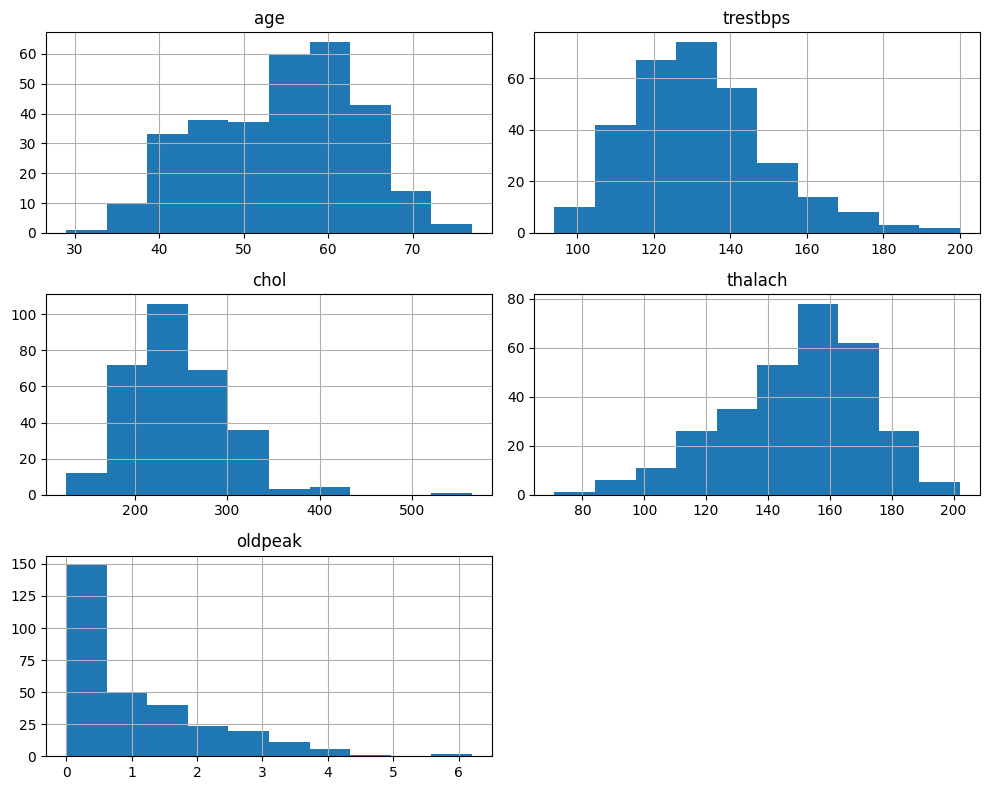

In [7]:
# Define numerical, categorical columns before plotting
numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

# Plot histograms for numerical columns
raw[numeric_cols].hist(figsize=(10, 8), bins=10)
plt.tight_layout() #Adjusts the spacing between sub-charts
plt.show()


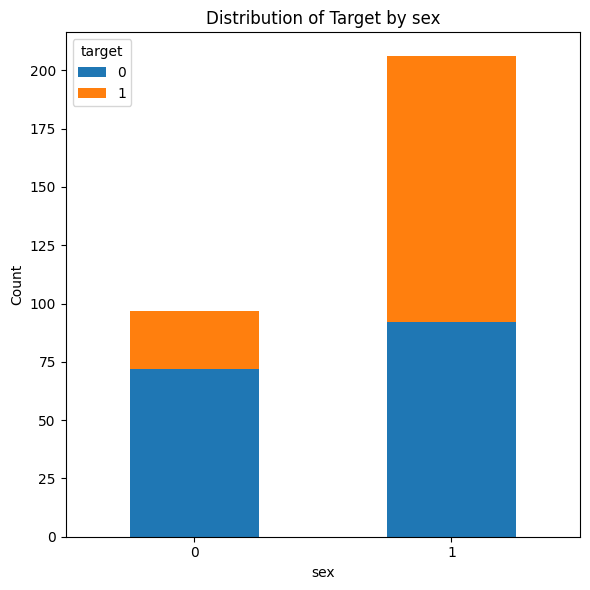

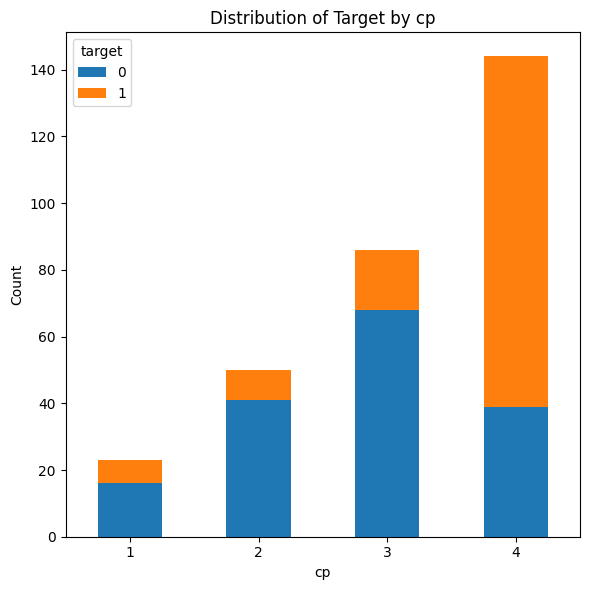

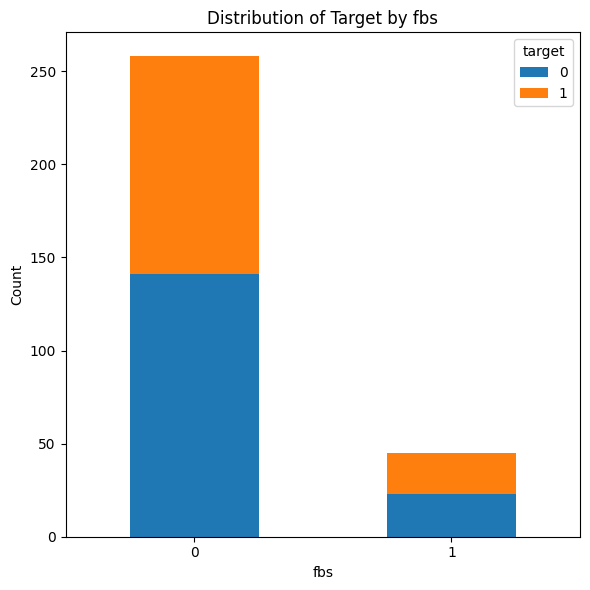

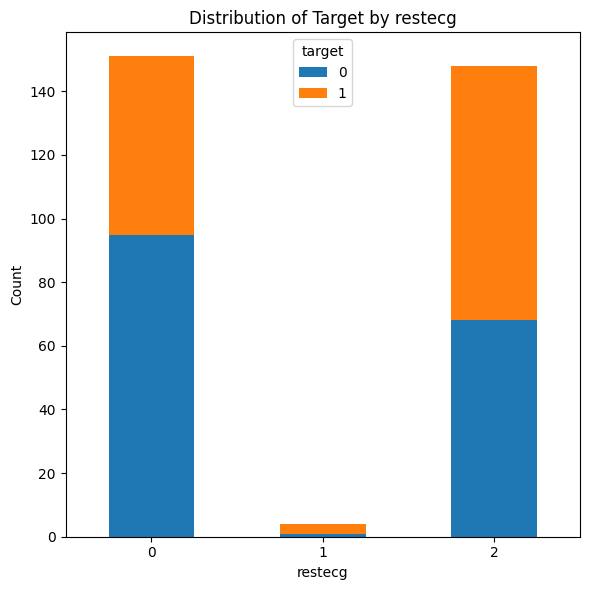

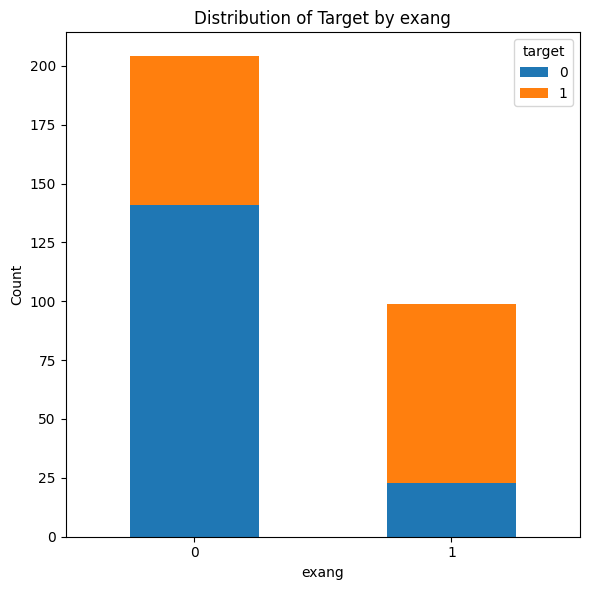

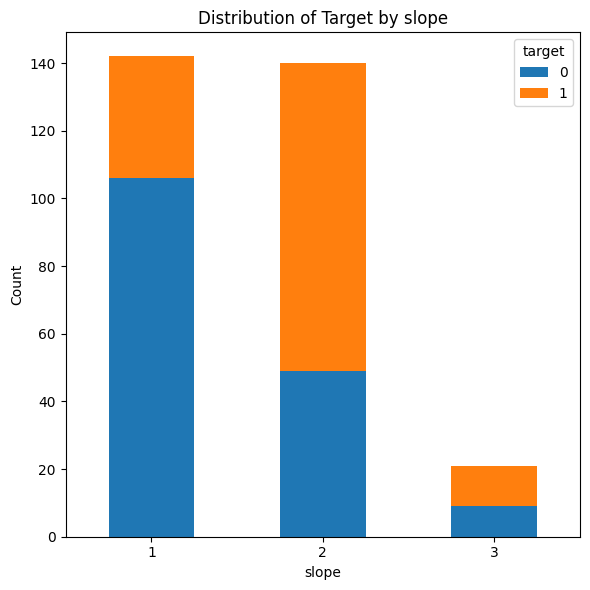

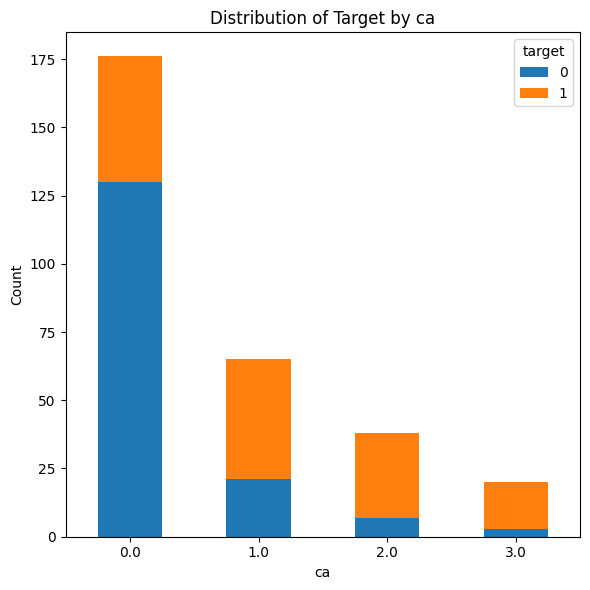

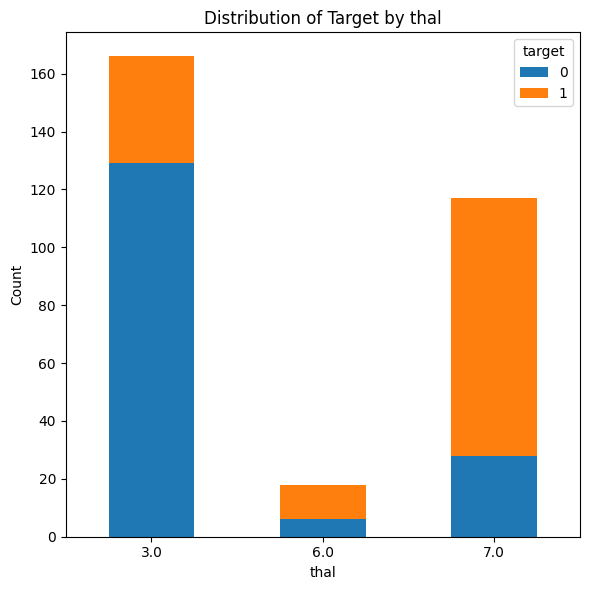

In [8]:
# Plot count plots for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(6, 6))
    raw.groupby([col, 'target']).size().unstack().plot(
        kind='bar',        # bar chart
        stacked=True,      # Stack the bars (shows how 'target' is split within each category).
        ax=plt.gca()       # Plot the chart onto the current figure.
    )
    plt.title(f'Distribution of Target by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=0) # X-axis labels horizontal for easy reading.
    plt.tight_layout()
    plt.show()

## 3.Visual Explorations

In [ ]:
X = raw.drop(columns=['target'])
y = raw['target']

# Colors by target
colors = ['tab:blue' if t==0 else 'tab:red' for t in y]

def scatter_with_regression(x_series, y_series, x_label, y_label, title):
    # Drop NaNs for fitting
    m = x_series.notna() & y_series.notna()
    x = x_series[m].values.reshape(-1, 1) # series will convert to numpy array and then reshape to 2D matrix having 1 column
    # scikit-learn requires 2D input for features
    yy = y_series[m].values

    # Fit linear regression
    if len(x) > 1:
        model = LinearRegression()
        model.fit(x, yy)
        # Create line
        x_line = np.linspace(x.min(), x.max(), 100).reshape(-1,1) # create 100 points between x min and x max
        y_pred = model.predict(x_line)
    else:
        x_line, y_pred = None, None

    # Plot scatter
    plt.figure()
    plt.scatter(x_series, y_series, c=colors, alpha=0.7)
    plt.xlabel(x_label); plt.ylabel(y_label)
    plt.title(title)

    # Plot regression line
    if x_line is not None:
        plt.plot(x_line.ravel(), y_pred) # Convert x_line from 2D to 1D
    plt.tight_layout()
    plt.show()

### Analyse 'age' with 'chol', 'trestbps', 'thalach' column

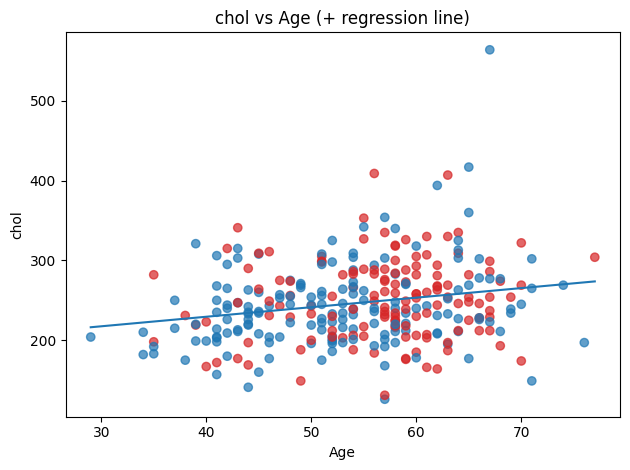

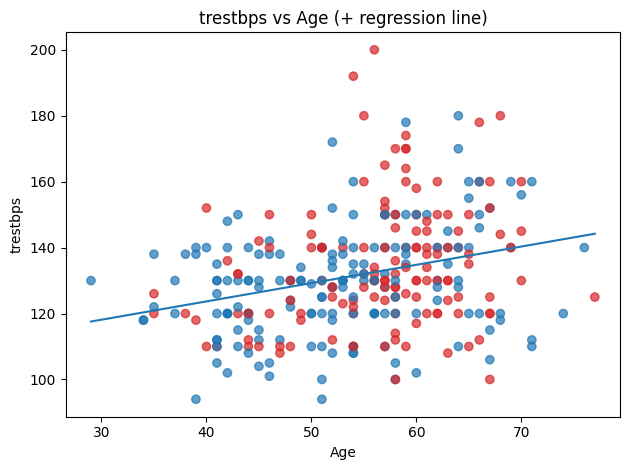

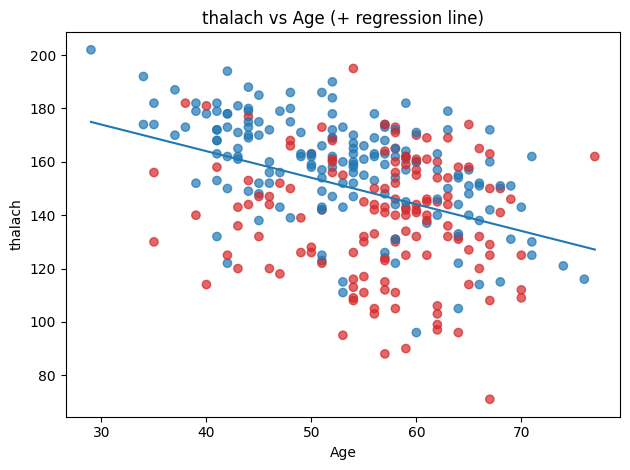

In [10]:
# Scatter + regression for selected pairs
if 'age' in X.columns:
    for col in ['chol', 'trestbps', 'thalach']:
        if col in X.columns:
            scatter_with_regression(X['age'], X[col], 'Age', col, f'{col} vs Age (+ regression line)')


/tmp/ipykernel_4191/2493011418.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vals = X.groupby(age_bins)[m].mean()


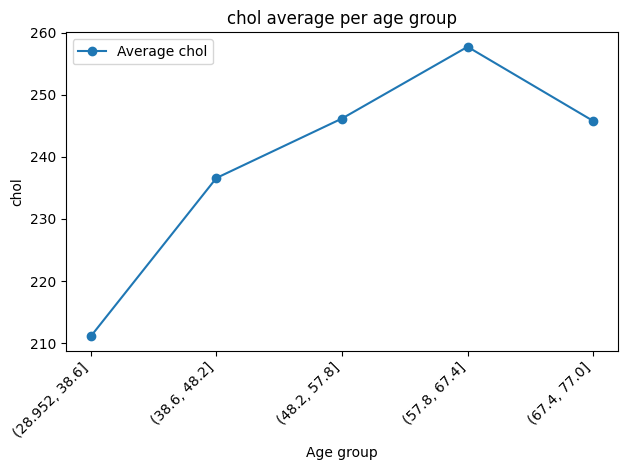

/tmp/ipykernel_4191/2493011418.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vals = X.groupby(age_bins)[m].mean()


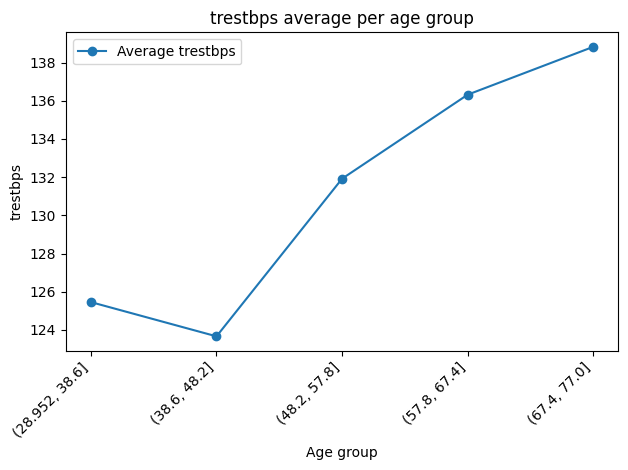

/tmp/ipykernel_4191/2493011418.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vals = X.groupby(age_bins)[m].mean()


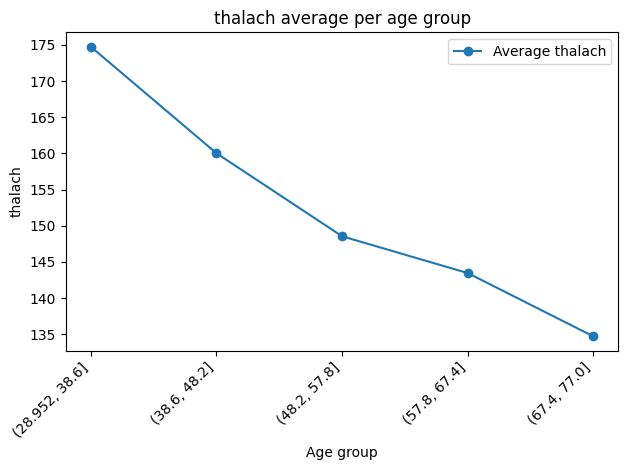

In [ ]:
# Group means by age bins
if 'age' in X.columns:
    age_bins = pd.cut(X['age'], bins=5)
    for m in ['chol','trestbps','thalach']:
        if m in X.columns:
            plt.figure()
            avg_vals = X.groupby(age_bins)[m].mean() # Calculate mean of m ('chol','trestbps','thalach') for each age bin
            plt.plot(range(len(avg_vals)), avg_vals, marker='o', label=f'Average {m}')
            plt.xticks(range(len(avg_vals)), [str(i) for i in avg_vals.index], rotation=45, ha='right') # set x ticks for 5 age groups, label is age bin range
            plt.xlabel('Age group'); plt.ylabel(m)
            plt.title(f'{m} average per age group')
            plt.legend(); plt.tight_layout(); plt.show()


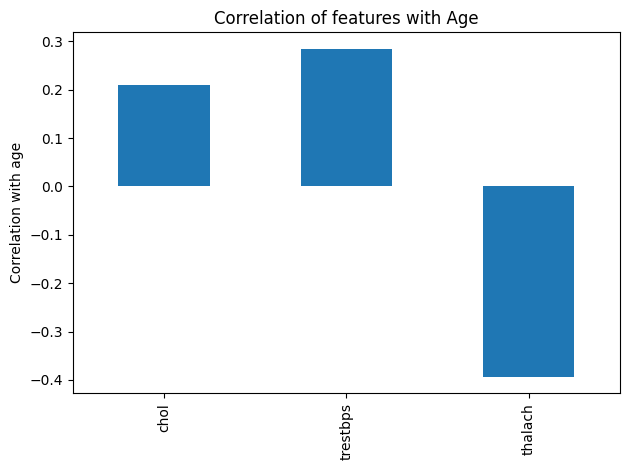

In [16]:
# Correlation with age
num_df = X[['age','chol','trestbps','thalach']].copy()
# Calculate correlation of each feature with 'age', excluding 'age' itself
corr = num_df.corr(numeric_only=True)['age'].drop('age')
plt.figure()
corr.plot(kind='bar')
plt.ylabel('Correlation with age')
plt.title('Correlation of features with Age')
plt.tight_layout()
plt.show()

## 4.Data Post-processing

🤔**What is data post-processing?**


### 4.1 Raw Dataset

### 4.2 Feature Engineering Dataset

In [13]:
# zip folder
!zip -r dataset.zip splits

zsh:1: command not found: zip
